<a href="https://www.kaggle.com/victortrigo/cnn-para-diagnostico-de-neumon-a?scriptVersionId=85403126" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# CNN Pneumonia

In [1]:
import tensorflow as tf
from tensorflow.keras import models, optimizers, regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cv2
import os


# import warnings
# warnings.filterwarnings("ignore")

## ETL

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

OpenCV(4.5.4-dev) /tmp/pip-req-build-0culq997/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.4-dev) /tmp/pip-req-build-0culq997/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


OpenCV(4.5.4-dev) /tmp/pip-req-build-0culq997/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.4-dev) /tmp/pip-req-build-0culq997/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [4]:
l = np.random.binomial(1, 0.1, 5216)

x_train = []
y_train = []

x_val = []
y_val = []

for i in range(1,5216):
    if l[i] == 0:
            x_train.append(train[i][0])
            y_train.append(train[i][1])
    else:
            x_val.append(train[i][0])
            y_val.append(train[i][1])

In [5]:
x_test = []
y_test = []

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

In [6]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [7]:
x_train = x_train.reshape(x_train.shape[0], img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(x_val.shape[0], img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(x_test.shape[0], img_size, img_size, 1)
y_test = np.array(y_test)

In [8]:
y_train = tf.keras.utils.to_categorical(
    y_train, num_classes=2, dtype='float32'
)

y_val = tf.keras.utils.to_categorical(
    y_val, num_classes=2, dtype='float32'
)

y_test = tf.keras.utils.to_categorical(
    y_test, num_classes=2, dtype='float32'
)

In [9]:
print('train data image: ', x_train.shape)
print('test data image: ', x_test.shape)
print('val data image: ', x_val.shape)

train data image:  (4713, 150, 150, 1)
test data image:  (624, 150, 150, 1)
val data image:  (502, 150, 150, 1)


In [10]:
print('train data image: ', y_train.shape)
print('test data image: ', y_test.shape)
print('val data image: ', y_val.shape)

train data image:  (4713, 2)
test data image:  (624, 2)
val data image:  (502, 2)


## Data Viz

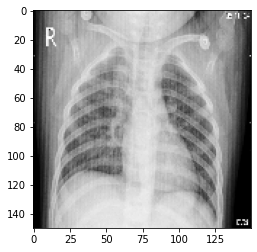

In [11]:
plt.imshow(x_train[0], cmap='gray')

## Model

In [12]:
datagen = ImageDataGenerator(rotation_range=15,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  horizontal_flip=True,
                  vertical_flip=True
)

In [13]:
checkpoint = ModelCheckpoint('mejor_modelo.hdf5', 
                             verbose=1, 
                             save_best_only=True, 
                             monitor='val_accuracy'
)

In [14]:
# model = Sequential()

# ## conv 1
# model.add(Conv2D(base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizers), input_shape=x_train.shape[1:]))
# model.add(Activation('relu'))
# model.add(BatchNormalization())

# ## conv 2
# model.add(Conv2D(base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizers)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))

# ## conv 3
# model.add(Conv2D(2*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizers)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# ## conv 4
# model.add(Conv2D(2*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizers)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.3))

# ## conv 5
# model.add(Conv2D(4*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizers)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())

# ## conv 6
# model.add(Conv2D(4*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizers)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.4))

# ## Clasificacion - Flatten
# model.add(Flatten())
# model.add(Dense(2, activation='softmax'))

# model.summary()

In [15]:
base_filtros = 32
w_regularizers = 1e-5

In [16]:
model = Sequential()

model.add(Conv2D(base_filtros,   (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizers), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizers)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 150, 150, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0

2022-01-16 21:51:01.306036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-16 21:51:01.432257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-16 21:51:01.432969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-16 21:51:01.434149: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy']
)

In [18]:
hist = model.fit(datagen.flow(x_train, y_train),
                 callbacks=[checkpoint],
                 steps_per_epoch=40,
                 epochs=60,
                 verbose=2,
                 validation_data=(datagen.flow(x_val, y_val))
)

2022-01-16 21:51:04.362669: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-01-16 21:51:05.882332: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


40/40 - 10s - loss: 6.4241 - accuracy: 0.7906 - val_loss: 0.6347 - val_accuracy: 0.7590

Epoch 00001: val_accuracy improved from -inf to 0.75896, saving model to mejor_modelo.hdf5
Epoch 2/60
40/40 - 3s - loss: 3.1264 - accuracy: 0.8594 - val_loss: 2.6236 - val_accuracy: 0.2709

Epoch 00002: val_accuracy did not improve from 0.75896
Epoch 3/60
40/40 - 3s - loss: 4.3124 - accuracy: 0.8484 - val_loss: 7.8238 - val_accuracy: 0.2510

Epoch 00003: val_accuracy did not improve from 0.75896
Epoch 4/60
40/40 - 3s - loss: 3.7251 - accuracy: 0.8789 - val_loss: 10.3234 - val_accuracy: 0.2510

Epoch 00004: val_accuracy did not improve from 0.75896
Epoch 5/60
40/40 - 4s - loss: 3.5860 - accuracy: 0.8735 - val_loss: 6.1706 - val_accuracy: 0.2590

Epoch 00005: val_accuracy did not improve from 0.75896
Epoch 6/60
40/40 - 3s - loss: 4.2619 - accuracy: 0.8648 - val_loss: 8.5981 - val_accuracy: 0.2530

Epoch 00006: val_accuracy did not improve from 0.75896
Epoch 7/60
40/40 - 3s - loss: 4.1241 - accuracy: 

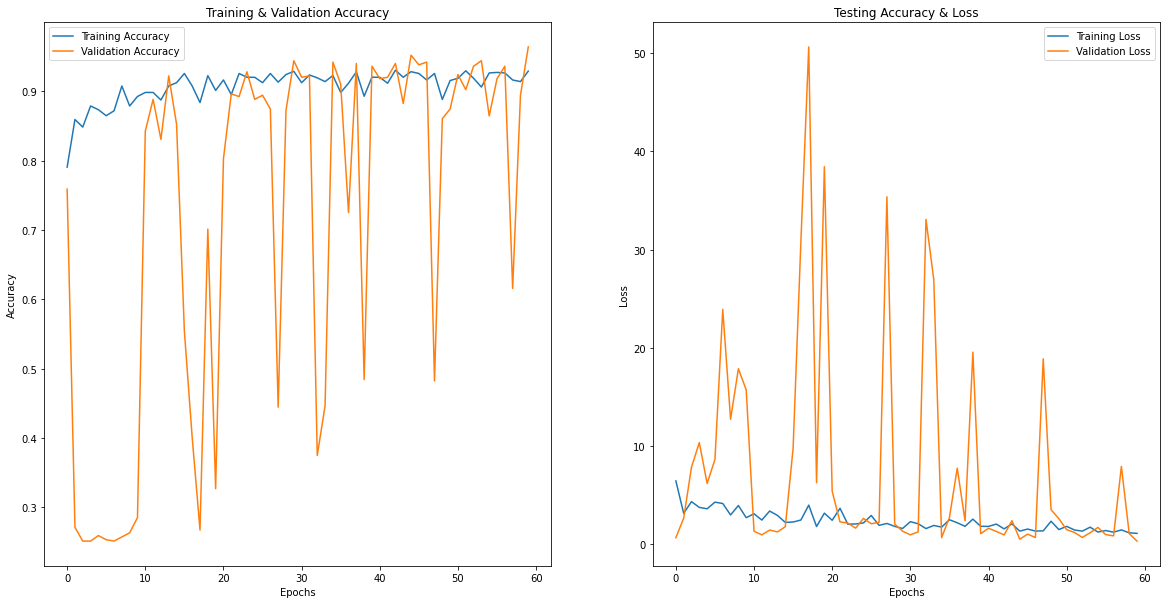

In [19]:
epochs = [i for i in range(60)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(epochs, hist.history['accuracy'],     label='Training Accuracy')
ax[0].plot(epochs, hist.history['val_accuracy'], label= 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, hist.history['loss'],     label = 'Training Loss')
ax[1].plot(epochs, hist.history['val_loss'], label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [20]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 10ms/step - loss: 3.8397 - accuracy: 0.8125
Loss of the model is -  3.839710235595703
20/20 [==============================] - 0s 8ms/step - loss: 3.8397 - accuracy: 0.8125
Accuracy of the model is -  81.25 %


In [21]:
model2 = load_model('./mejor_modelo.hdf5')

In [22]:
print("Loss of the model is - " , model2.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model2.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 10ms/step - loss: 3.8397 - accuracy: 0.8125
Loss of the model is -  3.839710235595703
20/20 [==============================] - 0s 9ms/step - loss: 3.8397 - accuracy: 0.8125
Accuracy of the model is -  81.25 %
